In [5]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 9)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [16]:
set.seed(2022)

weather_data <- read_csv("https://raw.githubusercontent.com/hyunseokjg/DSCI100-Group15-Project/main/data/testing_set.csv")
weather_data

#Let's remove the very rare weather classes for simplicity and so we do not overreppresent them when we balance our data

filtered_weather_data <- weather_data %>%
    filter(Weather != "Heavy Rain", 
           Weather != "Moderate Rain",
           Weather != "Clear",
           Weather != "Moderate Rain,Fog") %>%
    mutate(Weather = as_factor(Weather)) %>%
    sample_n(500)
filtered_weather_data

#Now we can split our dataset into training and testing sets using the initial_split function so we don't create our model with the same
#data that we will use to test it later on.

weather_split <- initial_split(filtered_weather_data, prop = 0.75, strata = Weather)
weather_train = training(weather_split)
weather_test = testing(weather_split)

Parsed with column specification:
cols(
  Temp = col_double(),
  Humid = col_double(),
  Wind_Spd = col_double(),
  Vis = col_double(),
  Press = col_double(),
  Weather = col_character()
)



Temp,Humid,Wind_Spd,Vis,Press,Weather
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
12.8,100,4,32.2,101.78,Mostly Cloudy
10.4,100,4,32.2,101.72,Mostly Cloudy
15.3,80,3,48.3,101.72,Mostly Cloudy
16.8,85,19,48.3,101.65,Mostly Cloudy
17.2,84,18,48.3,101.54,Cloudy
⋮,⋮,⋮,⋮,⋮,⋮
15.7,81,12,32.2,102.19,Cloudy
17.3,72,9,48.3,102.19,Mostly Cloudy
16.4,69,15,32.2,102.14,Mainly Clear


Temp,Humid,Wind_Spd,Vis,Press,Weather
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
15.9,81,18,48.3,100.73,Rain Showers
12.0,84,28,32.2,101.89,Mostly Cloudy
15.3,96,21,24.1,100.54,Rain
15.6,77,16,48.3,101.49,Mostly Cloudy
19.0,74,11,48.3,101.18,Cloudy
⋮,⋮,⋮,⋮,⋮,⋮
13.1,83,8,32.2,102.08,Mainly Clear
18.6,79,18,48.3,100.48,Mostly Cloudy
18.6,79,18,48.3,100.48,Mostly Cloudy


`summarise()` ungrouping output (override with `.groups` argument)



Weather,n,percent
<fct>,<int>,<dbl>
Mostly Cloudy,113,29.97347
Cloudy,84,22.28117
Rain Showers,30,7.95756
Rain,103,27.32095
Mainly Clear,47,12.46684


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8886205,5,0.02369216,Model01
2,accuracy,multiclass,0.8886205,5,0.02369216,Model02
3,accuracy,multiclass,0.7347412,5,0.02311859,Model03
4,accuracy,multiclass,0.6975389,5,0.01000804,Model04
5,accuracy,multiclass,0.6392444,5,0.01326991,Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
27,accuracy,multiclass,0.4379211,5,0.01305325,Model27
28,accuracy,multiclass,0.4326561,5,0.01232313,Model28
29,accuracy,multiclass,0.4272886,5,0.00917682,Model29


.pred_class,Weather
<fct>,<fct>
Mostly Cloudy,Mostly Cloudy
Mostly Cloudy,Mostly Cloudy
Cloudy,Cloudy
Mainly Clear,Mainly Clear
Rain Showers,Rain Showers
⋮,⋮
Mainly Clear,Mainly Clear
Cloudy,Cloudy
Mostly Cloudy,Mostly Cloudy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9268293


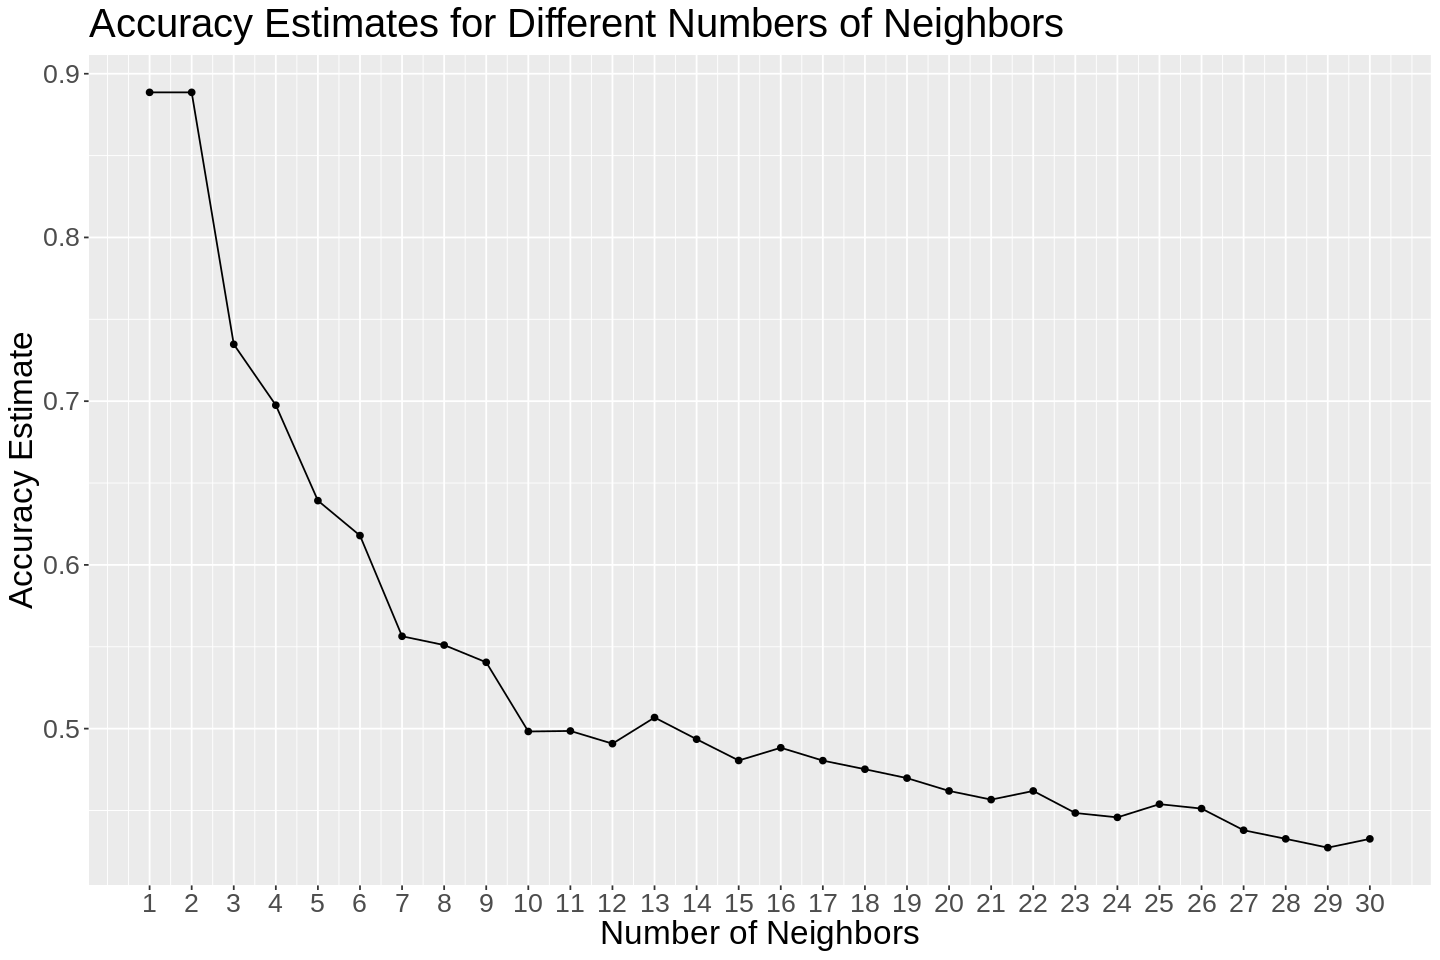

In [15]:
set.seed(2022)

#check to see if proportions of data are close enough to use or if we should scale up / remove some
#of the other weather classifications

number_rows <- nrow(weather_train)

proportions <- weather_train %>%
    group_by(Weather) %>%
    summarize(n = n()) %>%
    mutate(percent = 100*n/number_rows)
proportions

#make recipe and model with cross validation to find k

weather_recipe <- recipe(Weather ~ ., data = weather_train) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

weather_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

weather_vfold <- vfold_cv(weather_train, v = 5, strata = Weather) #need set seed for this func

k_grid <- tibble(neighbors = 1:30)

weather_fit <- workflow() %>%
    add_recipe(weather_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

#find accuracy for different values of k on our model

weather_accuracy <- weather_fit %>%
    filter(.metric == "accuracy")
weather_accuracy

#create line plot with data points for accuracy estimate vs neighbors to find optimal k value
#(looking for high accuracy estimate with high values of accuracy for nearby values of k as well)

options(repr.plot.height = 8, repr.plot.width = 12)
finding_k_plot <- ggplot(weather_accuracy, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
finding_k_plot

#retrain our model with the newfound value of k and fit it to our training data

weather_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) %>%  ## must use value of k determined above
    set_engine("kknn") %>%
    set_mode("classification")

weather_fit_final <- workflow() %>%
    add_recipe(weather_recipe) %>%
    add_model(weather_model) %>%
    fit(data = weather_train)

#we can now use our fitted model to predict the weather for our testing data set

weather_predictions <- predict(weather_fit_final, weather_test) %>%
    bind_cols(weather_test) %>%
    select(.pred_class, Weather)
weather_predictions

#we can use the metrics function to see how accurate our model was at predicting weather values 
#on the testing dataset

weather_metrics <- weather_predictions %>%
    metrics(truth = Weather, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
weather_metrics

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



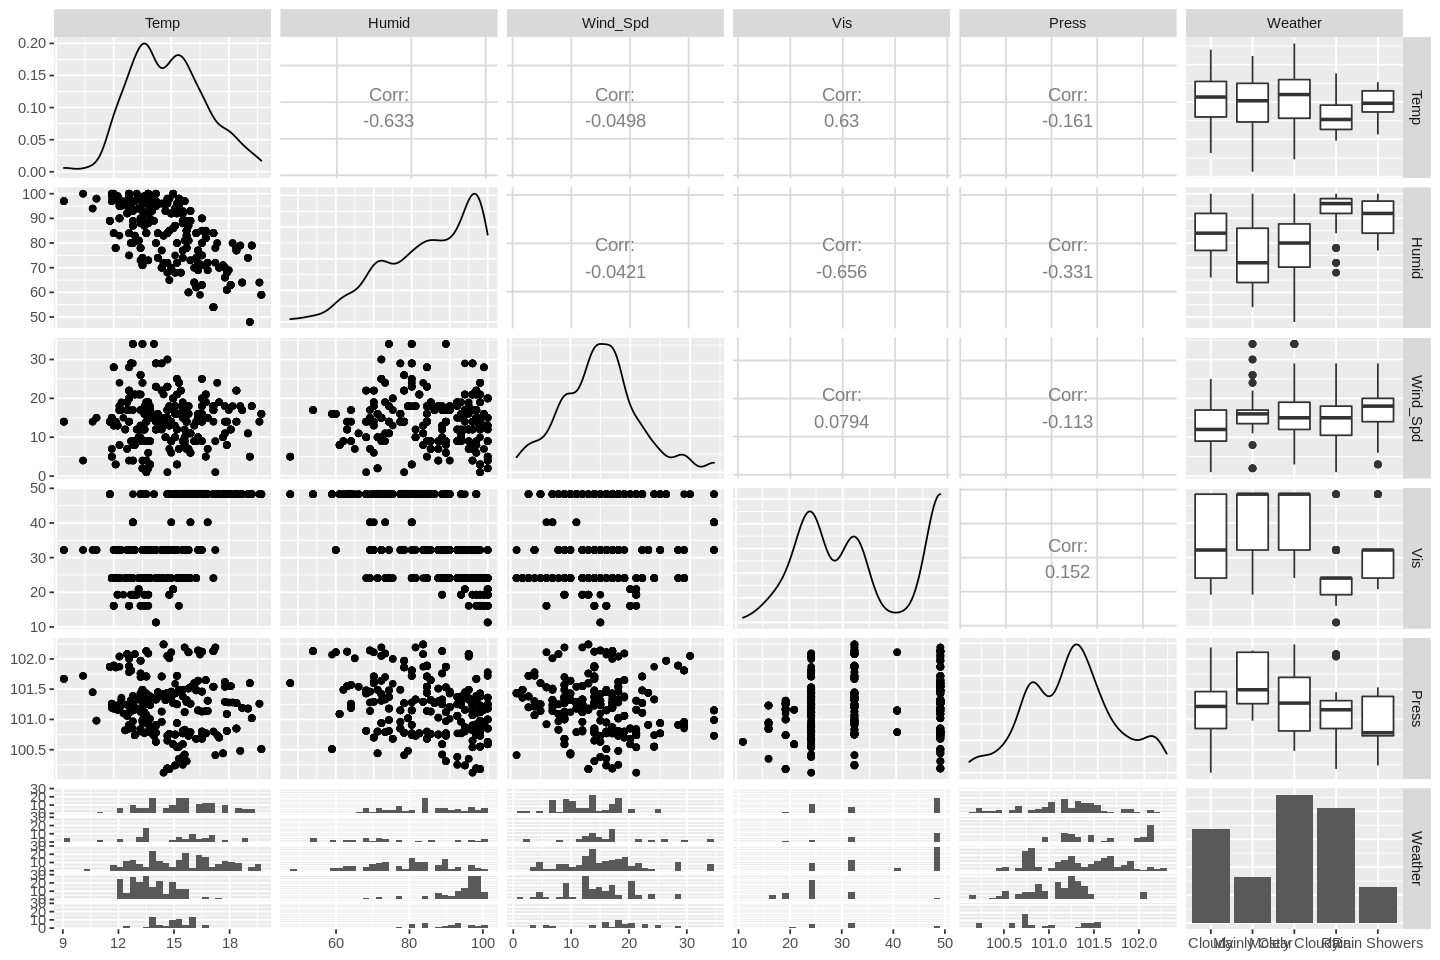

In [6]:
ggpairs(weather_train)